# BCM Rule - recurrent network

## Single postsynaptic neuron

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Updating functions for a single neuron $y$, its weights $w$ and the threshold $\theta$:
$$ \mathbf{y}(t) = \mathbf{w}\mathbf{y} $$
$$ \frac{d\mathbf{w}}{dt} = \eta \mathbf{y}(\mathbf{y}(t)(\mathbf{y}(t)-\mathbf{\theta}))^T $$
$$ \frac{d\mathbf{\theta}}{dt} = \frac{\mathbf{y}^2}{y_0} $$

In [39]:
def simple_network(Y_NUM=2,  TOT_TIME=5, STEPS_DIM=0.001, INPUT_RATE = 20,
                   TARGET_RATE=10, THETA_START=0.07, ETA=float('1e-4'),TAU=0.01):
    
    

    STEPS_N = round(TOT_TIME/STEPS_DIM)

    time_vect = np.linspace(0,TOT_TIME, STEPS_N)

    theta = np.zeros((Y_NUM,STEPS_N))
    theta[:,0] = THETA_START

    #w = np.random.random([Y_NUM, Y_NUM, STEPS_N])
    w = np.random.random([Y_NUM, Y_NUM])
    rand_seq = np.random.randint(0,2,STEPS_N)
    #x = np.array([rand_seq, 1-rand_seq])*INPUT_RATE
    y = np.zeros((Y_NUM,STEPS_N))
    y[:,0] = np.random.randint(0,INPUT_RATE,Y_NUM)

    for i in range(1,STEPS_N):
        y[:,i] = y[:,i-1] + STEPS_DIM*(-y[:,i-1] + w[:,:].dot(y[:,i-1]))
        
        w[:,:] = w[:,:] + ETA*STEPS_DIM*(
            y[:,i-1, None] * (y[:,i, None]*(y[:,i, None] - theta[:,i-1, None])).T).T 
        
        theta[:,i] = theta[:,i-1] + (STEPS_DIM/TAU) * (-theta[:,i-1] + (y[:,i]**2)/TARGET_RATE)

        w[w < 0] = 0
    
    return y, w, theta, time_vect

In [40]:
y, w, theta, time_vect = simple_network(Y_NUM=10, THETA_START=20, INPUT_RATE = 20, TOT_TIME=50)

Plot the values of y, the weights and theta:

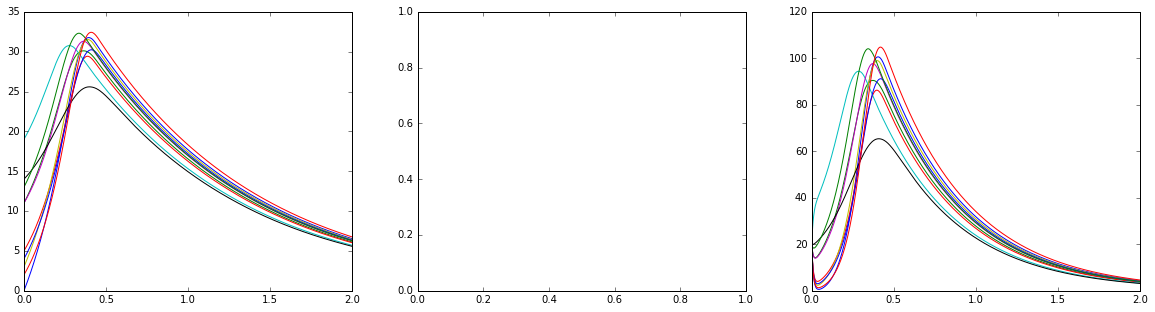

In [41]:
x_max = 2

f, ax = plt.subplots(1,3, figsize = (20,5))
for i in range(y.shape[0]):
    ax[0].plot(time_vect, y[i,:])
    #plt.ylim(0, 0.001)
    ax[0].set_xlim(0, x_max)

    #ax[1].plot(time_vect, w[i,0,:])
    #ax[1].plot(time_vect, w[i,1,:])
    #plt.ylim(-50, 10)
    #ax[1].set_xlim(0, x_max)

    ax[2].plot(time_vect, theta[i,:])
    ax[2].set_xlim(0, x_max)

plt.show()


## Multiple neurons

Now we can look at a simple network with two input neurons converging on three postsinaptic neurons:    

In [138]:
y, w, theta, time_vect = simple_network(X_NUM=2, Y_NUM=3)